#  SN Rate Metric


utilities needed the code: h5py, psnid (from SNANA package);

**Import lsst and utilities packages**

**lc_lsst** is a python module that allow to produce the template_lc.txt file (see below for the specifics) with the template lc in a range in redshift that has to be specified by the user


In [1]:
import sys, os, h5py, pickle, warnings, subprocess
sys.path.append('/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs')
from opsimUtils import *
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from lsst.sims.maf.metrics import BaseMetric
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
from lsst.sims.utils import equatorialFromGalactic, galacticFromEquatorial
from lsst.sims.maf.utils import m52snr, radec2pix
import pandas as pd
from pylab import cm
import time
from itertools import groupby
os.environ['SNANA_DIR']='/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs/SNRate_Simulations/SNANA'
os.environ['SNDATA_ROOT']='/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs/SNRate_Simulations/SNDATA_ROOT'
os.environ['LSST_DIR']='/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs/SNRate_Simulations/util_snrmetric'
%matplotlib inline

The following cell imports the opsims database names and create empty files to upload the results in.

In [2]:
your_username = 'fragosta'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.7/'
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRatev1.7'.format(your_username)

if not os.path.exists(os.path.abspath(outDir)):
    os.mkdir(os.path.abspath(outDir))
    
dbRuns = show_opsims(dbDir)
# two dictionary are returned by the following function, 
# One (opSimDbs) is a dictionary storing all database objects
# Another (resultDbs) is a dictionary consist of the objects directing MAF where to save metric metadata
# Both dictionaries are indexed by OpSim run names
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)

################ LC TEMPLATE #############

We import the module to simulate the K-corrected templates' ligh curves within a given redshift range. The LC span a range in redshift, it is given by the user, from z_min to z_max  with a step still setted by the user interactivelly.

In [3]:
import template_lc

In [64]:
temp = template_lc.template_lc(sn_group=sn_group ,
                               z_min=0.1,z_max= 0.9,z_step=0.1)
obs_template = temp.run()

I'm reading the templates
1990N g B 0.1
1990N r R 0.1
1990N i R 0.1
1990N g B 0.2
1990N r B 0.2
1990N i V 0.2
1990N g B 0.3
1990N r B 0.3
1990N i V 0.3
1990N g B 0.4
1990N r B 0.4
1990N i V 0.4
1990N g B 0.5
1990N r B 0.5
1990N i B 0.5
1990N g B 0.6
1990N r B 0.6
1990N i B 0.6
1990N g B 0.7
1990N r B 0.7
1990N i B 0.7
1990N g B 0.8
1990N r B 0.8
1990N i B 0.8
1992A g B 0.1
1992A r R 0.1
1992A i R 0.1
1992A g B 0.2
1992A r B 0.2
1992A i V 0.2
1992A g B 0.3
1992A r B 0.3
1992A i V 0.3
1992A g B 0.4
1992A r B 0.4
1992A i V 0.4
1992A g B 0.5
1992A r B 0.5
1992A i B 0.5
1992A g B 0.6
1992A r B 0.6
1992A i B 0.6
1992A g B 0.7
1992A r B 0.7
1992A i B 0.7
1992A g B 0.8
1992A r B 0.8
1992A i B 0.8
1994D g B 0.1
1994D r R 0.1
1994D i R 0.1
1994D g B 0.2
1994D r B 0.2
1994D i V 0.2
1994D g B 0.3
1994D r B 0.3
1994D i V 0.3
1994D g B 0.4
1994D r B 0.4
1994D i V 0.4
1994D g B 0.5
1994D r B 0.5
1994D i B 0.5
1994D g B 0.6
1994D r B 0.6
1994D i B 0.6
1994D g B 0.7
1994D r B 0.7
1994D i B 0.7
1994D g 

In [10]:
obs_template['magobs'].keys()

dict_keys(['1990N', '1992A', '1994D', '2002bo', '1991T', '1999ee', '1991bg', '2000cx', '2002cx', '1999em', '2004et', '2009bw', '1999br', '1999gi', '2005cs', '1992H', '1993J', '2008ax', '1987A', '2010jl', '1998S', '1997cy', '2005gj', '2009jf', '2008D', '1994I', '2004aw', '2007gr', '1998bw', '2008es'])

Check the number of filters for which the template's max is above the depth threshold for each template

In [30]:
mlc = {f: np.array([min(obs_template['magobs'][t][0.8][f]) for t in obs_template['magobs'].keys()]) for f in ['r','g','i']}
mlc01 = {f: np.array([min(obs_template['magobs'][t][0.1][f]) for t in obs_template['magobs'].keys()]) for f in ['r','g','i']}

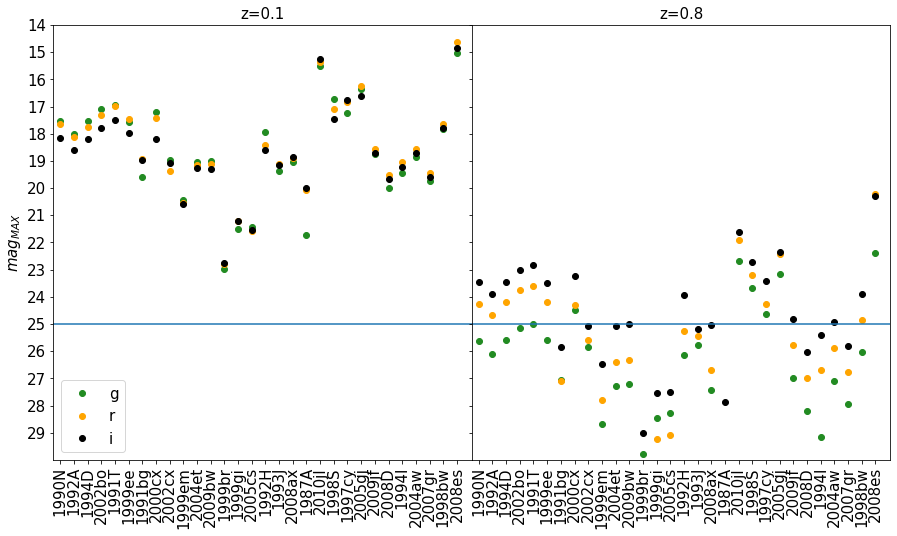

In [57]:
fig = plt.figure(figsize=(15,8))
gs = fig.add_gridspec(1,2, wspace=0)
ax = gs.subplots(sharey=True)

for f,c in zip(['g','r','i'],['forestgreen','orange','black']):
    ax[0].plot(np.arange(len(obs_template['magobs'])),mlc01[f],'o',color=c,label=f)
    ax[1].plot(np.arange(len(obs_template['magobs'])),mlc[f],'o',color=c,label=f)
ax[1].set_title('z=0.8', fontsize=15)
ax[1].set_xlabel('')
ax[1].set_xlim([-0.5,30.1])
ax[1].set_yticks(np.arange(len(obs_template['magobs'])))
ax[1].set_xticks(np.arange(len(obs_template['magobs'])))
ax[1].set_xticklabels(obs_template['magobs'].keys(),rotation=90, fontsize=15)
ax[1].plot(np.linspace(-20,50,100),np.ones(100)*25,'-')
ax[1].tick_params(axis="both",labelsize=15)
ax[1].set_ylim([30,14])
ax[0].set_title('z=0.1', fontsize=15)
ax[0].legend(loc=3, fontsize=15)
ax[0].set_xlabel('')
ax[0].set_ylabel(r'$mag_{MAX}$', fontsize=15)
ax[0].set_xlim([-0.5,30.1])
ax[0].set_xticks(np.arange(len(obs_template['magobs'])))
ax[0].set_xticklabels(obs_template['magobs'].keys(),rotation=90, fontsize=15)
ax[0].plot(np.linspace(-20,50,100),np.ones(100)*25,'-')
ax[0].tick_params(axis="both",labelsize=15)
ax[0].set_ylim([30,14])
plt.show()

In [ ]:
temp = template_lc.template_lc(sn_group=sn_group ,
                               z_min=0.1,z_max= 0.9,z_step=0.1)
obs_template = temp.run()

obs_template['magobs'].keys()

mlc = {f: np.array([min(obs_template['magobs'][t][0.8][f]) for t in obs_template['magobs'].keys()]) for f in ['r','g','i']}
mlc01 = {f: np.array([min(obs_template['magobs'][t][0.1][f]) for t in obs_template['magobs'].keys()]) for f in ['r','g','i']}

db =np.array(list(obs_template['magobs'].keys()))
db[19]

fig = plt.figure(figsize=(15,8))
gs = fig.add_gridspec(1,2, wspace=0)
ax = gs.subplots(sharey=True)

for f,c in zip(['g','r','i'],['forestgreen','orange','black']):
    ax[0].plot(np.arange(len(obs_template['magobs'])),mlc01[f],'o',color=c,label=f)
    ax[1].plot(np.arange(len(obs_template['magobs'])),mlc[f],'o',color=c,label=f)
ax[1].set_title('z=0.8', fontsize=15)
ax[1].set_xlabel('')
ax[1].set_xlim([-0.5,30.1])
ax[1].set_yticks(np.arange(len(obs_template['magobs'])))
ax[1].set_xticks(np.arange(len(obs_template['magobs'])))
ax[1].set_xticklabels(obs_template['magobs'].keys(),rotation=90, fontsize=15)
ax[1].plot(np.linspace(-20,50,100),np.ones(100)*25,'-')
ax[1].tick_params(axis="both",labelsize=15)
ax[1].set_ylim([30,14])
ax[0].set_title('z=0.1', fontsize=15)
ax[0].legend(loc=3, fontsize=15)
ax[0].set_xlabel('')
ax[0].set_ylabel(r'$mag_{MAX}$', fontsize=15)
ax[0].set_xlim([-0.5,30.1])
ax[0].set_xticks(np.arange(len(obs_template['magobs'])))
ax[0].set_xticklabels(obs_template['magobs'].keys(),rotation=90, fontsize=15)
ax[0].plot(np.linspace(-20,50,100),np.ones(100)*25,'-')
ax[0].tick_params(axis="both",labelsize=15)
ax[0].set_ylim([30,14])
plt.show()

- get_Col is a metric that allows to extract specific columns from the Opsims database
- transientsmetric is a metric that estimates the classification and detection efficiency of the Opsims 

In [4]:
class get_Col(BaseMetric):
    def __init__(self,  metricName='get_Col',Col=['expMJD',
                 'fiveSigmaDepth','filter', 'fieldRA', 'fieldDec', 
                 'seeingFwhmEff'], dataout=False, **kwargs):
        
        """
    This metric aims to measure the detection and classification efficiency of SNe light curve.
    
    Parameters:
    ___________
    Survey Parameters:
        Col = an array with the column names form the Opsim database
    __________
    
    OUTPUT:
        Dictionary with the column values
        
    """
        
        self.Col= Col
                
        # if you want to get the light curve in output you need to define the metricDtype as object
        super(get_Col, self).__init__(self.Col,metricDtype='object', units='',
                                                       metricName=metricName, **kwargs)
        
    def run(self, dataSlice, slicePoint=None):
        
        # Sort the entire dataSlice in order of time.
        dataSlice.sort(order='observationStartMJD')
        r = {c:dataSlice[c] for c in self.Col}
        return r
            

In [5]:
class transientsmetric(BaseMetric):
    """
    This metric aims to measure the detection and classification efficiency of SNe light curve.
    
    Parameters:
    ___________
    Survey Parameters:
        mjdCol= MJD observations column name from Opsim database      (DEFAULT = expMJD) 
        m5Col= Magnitude limit column name from Opsim database      (DEFAULT = fiveSigmaDepth)
        filterCol= Filters column name from Opsim database      (DEFAULT = filter)
        RACol= RA column name from Opsim database      (DEFAULT = fieldRA)
        DecCol= Dec column name from Opsim database      (DEFAULT = fieldDec)
        surveyDuration= Survey Duration      (DEFAULT = 10)
        surveyStart= Survey start date      (DEFAULT = None)
   
    Template parameters:
        templates= dictionary with all the SNe templates     (DEFAULT= {'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],100)}})
        z = array with z min, z max and z step for the redshift range     (DEFAULT= [0.1,1,0.1])
        explosiontime = times of explosion array      (DEFAULT= None)
        
    
    Detection parameters:
        detectSNR= dictionary with SNR threshold for each filter    (DEFAULT = {'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5})
        nFilters= None or number to define the threshold number of filter to be detected  (DEFAULT = None)
        npoints= integer, threshold number of points detected on the lightcurve   (DEFAULT = 3)
        
    __________
    
    OUTPUT:
        dataout = True, Dictionary containing the coordinates of all the SNe detected, the time of explosions and the number of 
        detected and no-detected along with the number of classifies, no-classified and mis-classified SNe for each type
        
        dataout = False, fraction of detected SNe
        
    """
    def __init__(self, metricName='transientsmetric', mjdCol='expMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter', RACol='fieldRA', DecCol='fieldDec', 
                 ,surveyDuration=10.,surveyStart=None,
                 observedFilter=['g','r','i'],templates= {'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],100)}},
                 z=[0.1,1,0.1], explosiontime=None, 
                 detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5},
                 nFilters=None, npoints=3, dataout=False, **kwargs):
        
        "Survey Parameters"
        self.observedFilter= observedFilter
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.RACol = RACol
        self.DecCol=DecCol
        self.filterCol = filterCol
        self.surveyDuration = surveyDuration
        self.surveyStart = surveyStart 
        "templates"
        self.templates=templates
        "Parameters to generate magnitude for a template lc at different redshits and explosion times"
        self.z = z
        self.explosiontime = explosiontime    
        "Parametes to contrains the detections' selection"
        self.nFilters = nFilters
        self.npoints = npoints
        self.detectSNR = detectSNR
        "Paremeters to select the kind of output"
        self.dataout = dataout
        
        
        # if you want to get the light curve in output you need to define the metricDtype as object
        if self.dataout:
            super(transientsmetric, self).__init__(col=[self.mjdCol, self.m5Col, self.filterCol,self.RACol,self.DecCol,self.seeingCol],
                                                       metricDtype='object', units='',
                                                       metricName=metricName, **kwargs)
        else:
            super(transientsmetric, self).__init__(col=[self.mjdCol, self.m5Col, self.filterCol],
                                                       units='Fraction Detected', metricName=metricName,
                                                       **kwargs)
        
        
        
        
    
        # The SN template light curves are simulated at the redshifts in the redshift range  
        # K-correction is applied at each redshift z 
        zmin = self.z[0]
        zmax = self.z[1]
        zstep = self.z[2]
        temp = template_lc.template_lc(sn_group= self.templates, z_min=zmin,z_max= zmax,z_step=zstep)
        self.obs_template = temp.run()
        self.zrange = temp.zrange
        self.filtri = temp.filtri
        for j, z in enumerate(self.zrange):
                for ty in sngroups:       
                    for sty in sngroups[ty]:
                        for sn in sngroups[ty][sty][0]:
                            asciifile = 'snlc_{}_z={}.ascii'.format(sn,str(z))
                            ff = open(asciifile,'w')
                            if ty in ['Ia','Ibc']:    endTime = 50.*(1+z)
                            else:                     endTime =100.*(1+z)
                            for f in self.filtri:
                                for i,p in enumerate(self.obs_template['phobs'][sn][z][f]):
                                    if self.obs_template['phobs'][sn][z][f][i] > endTime: break    
                                    ff.write('{:.2f} {:.3f} {}\n'.format(p,self.obs_template['magobs'][sn][z][f][i],f))
                            ff.close()
                            
                            
             
    def read_lightCurve(self, asciifile):
        """Reads in an ascii file, from the simulated ligh curves, 3 columns: epoch, magnitude, filter

        Returns
        -------
        numpy.ndarray
            The data read from the ascii text file, in a numpy structured array with columns
            'ph' (phase / epoch, in days), 'mag' (magnitude), 'flt' (filter for the magnitude).
        """
        if not os.path.isfile(asciifile):
            raise IOError('Could not find lightcurve ascii file %s' % (asciifile))
        self.lcv_template = np.genfromtxt(asciifile, dtype=[('ph', 'f8'), ('mag', 'f8'), ('flt', 'S1')])
        self.transDuration = self.lcv_template['ph'].max() - self.lcv_template['ph'].min()

    def make_lightCurve(self, time, filters):
        """Turn lightcurve definition into magnitudes at a series of times.

        Parameters
        ----------
        time : numpy.ndarray
            The times of the observations.
        filters : numpy.ndarray
            The filters of the observations.

        Returns
        -------
        numpy.ndarray
             The magnitudes of the transient at the times and in the filters of the observations.
        """
        lcMags = np.zeros(time.size, dtype=float)
        for key in set(self.lcv_template['flt']):
            fMatch_ascii = np.where(np.array(self.lcv_template['flt']) == key)[0]
            # Interpolate the lightcurve template to the times of the observations, in this filter.
            temp_ph=np.array(self.lcv_template['ph'], float)[fMatch_ascii]-np.array(self.lcv_template['ph'], float)[fMatch_ascii][0]
            lc_ascii_filter = np.interp(time, temp_ph,
                                        np.array(self.lcv_template['mag'], float)[fMatch_ascii])
            lcMags[filters == key.decode("utf-8")] = lc_ascii_filter[filters == key.decode("utf-8")]
        return lcMags
    
    
    def run(self, dataSlice, slicePoint=None):
        
        # Sort the entire dataSlice in order of time.
        dataSlice.sort(order=self.mjdCol)
        
        # Check that surveyDuration is not larger than the time of observations we obtained.
        # (if it is, then the nTransMax will not be accurate).
        tSpan = (dataSlice[self.mjdCol].max() - dataSlice[self.mjdCol].min()) / 365.25
        surveyDuration = np.max([tSpan, self.surveyDuration])
        
        # We set the survey duration if it is not given as input
        if self.surveyStart is None:
            surveyStart = dataSlice[self.mjdCol].min()
        else:
            surveyStart = dataSlice[self.mjdCol].min() + 365*self.surveyStart
        
        
        """
        the array of the explosion dates has three possible setting:
            self.explosiontime = integer,  it sets the number of dates to drawn randomly from the Opsim database
            self.explosiontime = None, one date is randomly drawn from the Opsim database
            self.explosiontime = list or array, it sets the array containing the explosion dates
        """
        if isinstance(self.explosiontime, int):
            expl_t =np.random.choice(dataSlice[self.mjdCol],self.explosiontime)
        elif  self.explosiontime is None:
            expl_t=np.random.choice(dataSlice[self.mjdCol],1)
        elif isinstance(self.explosiontime, (list, tuple, np.ndarray)):
            expl_t=np.array(self.explosiontime)+surveyStart
            
        
        lc = {}
        filterNames = self.observedFilter
        filterN= ''.join(filterNames)
        fieldRA = np.median(dataSlice['fieldRA']) 
        fieldDec = np.median(dataSlice['fieldDec'])
        sngroups= self.templates
        expldist=[]
                
        if all(np.in1d(self.observedFilter, dataSlice[self.filterCol])): #check if all the filters for the observed lightcurves are available
            
            index_filter = np.in1d( dataSlice[self.filterCol], self.observedFilter) #filtri presenti nello slice
            obs_filter = dataSlice[self.filterCol][index_filter] #seleziono solo i filtri che ci sono 
            obs = dataSlice[self.mjdCol][index_filter]
            obs_m5 = dataSlice[self.m5Col][index_filter]
            
            classify =pd.DataFrame(index=self.zrange,columns=['pixId', 'Ia','Ibc','II','nlc','noClass'])
            classify['pixId']=radec2pix(16,np.radians(fieldRA),np.radians(fieldDec))
            for j, z in enumerate(self.zrange):
                """
                Observed light curve simulation step:
                """
                print('z={}'.format(z))
                sn_list = 0 #inizializzo indice per condate le SNe simulate
                nDetected = 0 #inizializzo indice per condate le SNe detected
                nNoDetected = 0    #inizializzo indice per condate le SNe non detected               
                listout=[]
                for ty in sngroups:
                    lc[ty]={}       
                    for sty in sngroups[ty]:
                        lc[ty][sty]={}
                        for sn in sngroups[ty][sty][0]:
                            lc[ty][sty][sn]={}          
                            asciifile = 'snlc_{}_z={}.ascii'.format(sn,str(z))
                            self.read_lightCurve(asciifile) # we read the simulated lightcurve at the given z
                          
                            for k,times in enumerate(expl_t):
                                expldist.append(times) 
               
                                indexlc = np.where((obs>= times) & (obs<=times+self.transDuration)) # we create a mask for all the observation whitin the transient duration
                                lcEpoch = (obs[indexlc] - surveyStart ) % self.transDuration # define the dates of the phases from the explosion time 
                                
                                if np.size(indexlc)>0:  
                                   
                
                                    
                                    lcMags = self.make_lightCurve(lcEpoch, obs_filter[indexlc]) # Generate the observed light curve magnitudes based on the SNR
                                    e = np.absolute(np.diff(lcEpoch))
                                    mask = np.where(e<0.3)
                                    if np.size(mask):
                                        lcopy = np.copy(lcMags)
                                        ecopy = np.copy(lcEpoch)
                                        lcopy[mask[0]] = (lcopy[mask[0]]+lcopy[mask[0]+1])/2
                                        ecopy[mask[0]] = (ecopy[mask[0]]+ecopy[mask[0]+1])/2
                                        #print([ecopy[mask[0]],ecopy[mask[0]+1]])
                                        lcMags = lcopy
                                        lcEpoch = ecopy
                                    lcSNR = m52snr(lcMags, obs_m5[indexlc])
                                    
                         
                                    lcpoints_AboveThresh = np.zeros(len(lcSNR), dtype=bool) 
                                    nfilt = []
                                    for f in self.observedFilter:                    
                                            filtermatch = np.where(obs_filter[indexlc] == f)
                                            lcpoints_AboveThresh[filtermatch] = np.where(lcSNR[filtermatch] >= self.detectSNR[f],True,False) # we define a mask for the detected points on the light curve
                                            
                                            Dpoints = np.sum(lcpoints_AboveThresh[filtermatch]) #counts the number of detected points
                                           
                                            if Dpoints>=self.npoints: nfilt.append(True) # check on the threshold
                                    
                                    lc[ty][sty][sn][times] = {}
                                    lc[ty][sty][sn][times]["Mags"] = lcMags
                                    lc[ty][sty][sn][times]["filter"] = obs_filter[indexlc]
                                    lc[ty][sty][sn][times]["SNR"] = lcSNR
                                    lc[ty][sty][sn][times]["Epoch"] = lcEpoch
                                    lc[ty][sty][sn][times]['detect'] = lcpoints_AboveThresh


                                    # producing a file to pass to PSNID for the classification

                                    mag = {}
                                    jd = {}
                                    merr = {}
                                    snr={}

                                    output  = 'SURVEY:  LSST \n'                
                                    output += 'SNID: {}_{} \n'.format(zz[0],k)
                                    output += 'IAUC:    UNKNOWN \n'             
                                    output +=  'RA:     '+str(fieldRA)+'  deg \n'
                                    output +=  'DECL:   '+str(fieldDec)+'  deg \n'
                                    output +=  'MWEBV:    0.0  MW E(B-V) \n'                           
                                    output +=  'REDSHIFT_FINAL:  '+str(z)+' +- '+'%5.3f' % self.z[2]+' (CMB)\n'
                                    output +=  'FILTERS:  {}   \n'.format(filterN)               
                                    output +=  ' \n'
                                    output += '# ======================================\n' 
                                    output += '# TERSE LIGHT CURVE OUTPUT\n' 
                                    output += '#\n' 
                                    output += 'NOBS: {} \n'.format(np.size(lcMags[lcpoints_AboveThresh])) 
                                    output += 'NVAR: 8 \n'
                                    output += 'VARLIST:  MJD  FLT FIELD   FLUXCAL   FLUXCALERR   SNR    MAG     MAGERR \n'
                                    for f in filterNames:
                                        filtermatch = np.where(obs_filter[indexlc] == f)
                                        detect= np.array(lc[ty][sty][sn][times]['detect'][filtermatch])
                                        mag[f] = lcMags[filtermatch][detect]
                                        jd[f] = obs[indexlc][filtermatch][detect]
                                        snr[f] = lcSNR[filtermatch][detect]
                                        merr[f] = 2.5*np.log10(1+1/snr[f])
                                        for h,j in enumerate(jd[f]):
         
                                            fl = 10**(-0.4*(mag[f][h]))*1e11
                                            if snr[f][h]>1: 
        
                                                flerr = fl/snr[f][h]/1.3
                                            else: 
        
                                                flerr = fl/1.1
                                            output += 'OBS: %9.3f   %s NULL  %7.3f  %7.3f  %7.3f  %7.3f  %7.3f \n' % (j,f,fl,flerr,snr[f][h],mag[f][h],merr[f][h])
                                    output +='END: '


                                    ofile = open(os.path.join('./LC','LSST_{}_{}_{}.dat'.format(sn,zz[1],k)),'w')
                                    ofile.write(output)
                                    ofile.close()        
                                    if self.nFilters: 
                                        if np.sum(nfilt) >= self.nFilters:
                                            snname='LSST_{}_{}_{}.dat'.format(sn,zz[1],k)
                                            snname+='\n'
                                            listout.append(snname)
                                            nDetected += 1
                                        else:
                                            nNoDetected += 1
                                    else:
                                        if any(nfilt): 
                                            snname='LSST_{}_{}_{}.dat'.format(sn,zz[1],k)
                                            snname+='\n'
                                            listout.append(snname)
                                            nDetected += 1
                                        else:
                                            nNoDetected += 1
                                
                                else:
                                    expl_t = np.delete(expl_t, np.where(expl_t==times))
                                    nNoDetected += 1
                listsn=open(os.path.join('./LC','LSST.LIST'),'w')
                listsn.writelines(listout)
                listsn.close()
                if not os.path.exists(os.path.join('./LC','LSST.README')):
                    dumbfile=open(os.path.join('./LC','LSST.README'),'w')
                    dumbfile.close()
                if not os.path.exists(os.path.join('./LC','LSST.IGNORE')):
                    dumbfile=open(os.path.join('./LC','LSST.IGNORE'),'w')
                    dumbfile.close()    
                
                
                """
                Classification step
                ____________________
                
                We run PSNID on the detected light curves, the PSNID output is saved as a string array in the variable r
                """
                classify['nlc'][z]= [nDetected, nNoDetected]
              
                if nDetected >0:
                    start_time_class = time.time()
                    r = subprocess.check_output([os.environ['SNANA_DIR']+'/bin/psnid.exe', os.environ['LSST_DIR']+'/PSNID_LSST.nml'], stderr=subprocess.STDOUT)
                    
                    print("--- {:.2f} minutes ---\n".format((float(time.time()) - float(start_time_class))/60))
                    
                    classify['Ia'][z]=0
                    classify['Ibc'][z]=0
                    classify['II'][z]=0
                    classify['UNKNOWN'][z]=0
                    clas=0
                    
                    # we search for classification flags in the variable r 
                    line= np.array(r.split())
                    types = np.where(line==b'type')
                    classify['Ia'][z]+=np.sum(line[types[0]+2]==b'Ia')
                    classify['Ibc'][z]+=np.sum(line[types[0]+2]==b'Ibc')
                    classify['II'][z]+=np.sum(line[types[0]+2]==b'II')
                    classify['UNKNOWN'][z]+=np.sum(line[types[0]+2]==b'UNKNOWN')
                    clas+= classify['Ia'][z]+classify['Ibc'][z]+classify['II'][z]
                    nNoclass = nDetected-clas+ classify['UNKNOWN'][z]                         
                
                    print('at z ={} for ty= {}: Ia={},Ibc={},II={}'.format(z, ty, classify['Ia'][z],classify['Ibc'][z],classify['II'][z]))
                    
                    classify['noClass'][z]=[nNoclass,clas]
                    print('detected:{}, nonDetected:{}, classificate:{}, nonClassificate:{}'.format(nDetected, 
                                                                                                    nNoDetected,
                                                                                                    clas,
                                                                                                    nNoclass))                         
            if self.dataout:
                explosiontime= np.array(expldist)
                return {'class':classify,'time_expl':explosiontime}

            else:
                N=np.sum([np.sum(classify[['Ia','Ibc','II','UNKNOWN']][z]) for z in self.zrange])/np.sum([np.sum(classify[['nlc']][z]) for z in self.zrange])            
                return float(N)



############################## LSST SURVEY PARAMETERS ######################

 **runName**: indicate the database from the Opsim;
 
 **opsdb** is a table with all the Opsim parameters for a given runName.

We need to define the number of years, the type of survey and the positiosn on the sky we want to analyse

**surveyDuration**: value in years of the survey;

**searchtype**: select if it wants to simulate a wide-fast-deep or a deep-drilling field;

In [6]:
surveyDuration = 1
init = 1
sqlconstraint_WFD = '(filter= "u" or filter= "g" or  filter = "r" or filter="i"  or filter="z")'
sqlconstraint_WFD+='and night>{} and night < {} '.format(init*365.25,(init+surveyDuration)*365.25 )
sqlconstraint_WFD+='and proposalId=1'

############################## SN position simulator  ######################
Here the RA and DEC of the observations are defined.

**slicermode**: indicate the type of slicer (the way you want to sort the data form the database)
 
        - SlicePoints: A spatial slicer that allows to select specifics pointings. A set of RA & DEC is passed to the API to extract approximated observational features in the injected positions.
         
        - HealpixSlicer: A spatial slicer that evaluates pointings on a healpix-based grid (the grid area divide the observed sky in nside x nside bins). The footprint is tasselated in a number of healpixels of equal area, which define the resolution of the observation.
        
        - Unislicer: This slicer simply returns the indexes of all data points. No slicing done at all.
   

In [7]:
#slicermode= input('select your Slicer (HealpixSlicer, SlicerPoints, UniSlicer): ')
#if slicermode =='HealpixSlicer':
nside = 16
slicer = slicers.HealpixSlicer(nside=nside)
#slicer=slicers.UniSlicer()
pixelarea = hp.nside2pixarea(nside,degrees=True)


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [54]:
#elif slicermode == 'SlicerPoints': 
names = ['ra', 'dec']#, 'seeing']    
npoint = 1  #  Note, we are going to loop over each object, so try not to make this a crazy huge number. 
transObjects = np.zeros(npoint, dtype=list(zip(names, [float]*len(names))))
# to random selection of position in the sky
l = ra_max
b = dec_max
#transObjects['ra'], transObjects['dec'] = equatorialFromGalactic(l,b) 
transObjects['ra'], transObjects['dec'] = l, b
#transObjects['seeing'] = np.random.rand(npoint)*2    
slicer = slicers.UserPointsSlicer(transObjects['ra'], transObjects['dec'], latLonDeg=True)
# Add any additional information about each object to the slicer
#slicer.slicePoints['seeing'] = transObjects['seeing']
#tshift = np.random.rand(nobjs)*surveyDuration*365
    
#elif slicermode=='UniSlicer':
#    slicer=slicers.UniSlicer()

##### OBSERVED LIGHT CURVES  ######################

This Class object produce the observed LC form a template that explode in a random time within the SurveyDuration. 
This Class is based on TransientAsciiMetric written by  fbb@nyu.edu, svalenti@lcogt.net.

It allows to estimate the fraction of observed transient and to obtain the observed LC from a template in input ( an ascii file per photometric band)

 - if **dataout=True**-> object, it is a python dictionary with all the informations about the LSST observed LC (MJD,SNR,MAG,EPOCH,RA,DEC);
 - if **dataout=False**-> number, it is the fraction of the detected transient during the survey time;

 Parameters:

asciifile : str The ascii file containing the inputs for the lightcurve (per filter):  File should contain three columns - ['ph', 'mag', 'flt'] - of phase/epoch (in days), magnitude (in a particular filter), and filter.

surveyDuration : float, optional   Length of survey (years). Default 10 or maximum of timespan of observations.

surveyStart : float, optional MJD for the survey start date. Default None (uses the time of the first observation at each pointing).

detectSNR : dict, optional An observation will be counted toward the discovery criteria if the light curve SNR is higher than detectSNR (specified per bandpass). Values must be provided for each filter which should be considered in the lightcurve.  Default is {'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}

explosiontime: time from the surveyStart for the SN to explode, if None it is a random epoch in Opsim MJD Column, if float is the time interval.

nFilters : int, optional    Number of filters that need to be observed for an object to be counted as detected. Default 1. 

Explosion time setting:

   - **n_expl** = integer or None, if integer is the number of random explosions in the survey time range;
   - **elplosiontime**= array or None, if array, each element of the array is the time from SurveyStart of the transient explosion;
   - if both, **n_expl** and **explosiontime**, are None it is picked one random time explosion per transient. 

In [19]:
sngroups ={'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],70),  
                    'IaBright':(['1991T','1999ee'],10), 
                    'IaFaint':(['1991bg'],15), 
                    'Iapec':(['2000cx','2002cx'],5)},
              'II':{'IIP':(['1999em','2004et','2009bw'],60),        # 60
                    'IIFaint':(['1999br','1999gi','2005cs'],10),    # 10
                    'IIL':(['1992H'],10),                           # 10
                    'IIb':(['1993J','2008ax'],10),                  # 10
                    'II87A':(['1987A'],10)},                        # 10
              'IIn':{'IIn':(['2010jl'],45),
                     'IIna':(['1998S'],45), 
                     'IIpec':(['1997cy','2005gj'],10)},
              'Ibc':{'Ib':(['2009jf','2008D'],27), 
                     'Ic':(['1994I','2004aw','2007gr'],68), 
                     'IcBL':(['1998bw'],5)}, 
              'SLSN' : {'SLSN':(['2008es'],100)}}

In [9]:
sngroupsIa ={'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],70),  
                    'IaBright':(['1991T','1999ee'],10), 
                    'IaFaint':(['1991bg'],15), 
                    'Iapec':(['2000cx','2002cx'],5)}}
sngroupsIbc = {'Ibc':{'Ib':(['2009jf','2008D'],27), 
                     'Ic':(['1994I','2004aw','2007gr'],68), 
                     'IcBL':(['1998bw'],5)}}
sngroupsII ={'II':{'IIP':(['1999em','2004et','2009bw'],60),        # 60
                    'IIFaint':(['1999br','1999gi','2005cs'],10),    # 10
                    'IIL':(['1992H'],10),                           # 10
                    'IIb':(['1993J','2008ax'],10),                  # 10
                    'II87A':(['1987A'],10)}}

### Test 

In [10]:
sngroupsIa ={'Ia':{'Ia':(['1990N'],100)}}

In [8]:
expl_range=np.arange(0,365,10)
expl_range.size

37

In [11]:
metriclcIa = transientsmetric(z=[0.1,0.9,0.7], metricName='Ia_test', mjdCol='observationStartMJD',\
                 m5Col='fiveSigmaDepth', filterCol='filter', RACol='fieldRA', DecCol='fieldDec',\
                              seeingCol='seeingFwhmEff',surveyDuration=surveyDuration, \
                              templates= sngroupsIa,explosiontime=expl_range,\
                              detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, nFilters=3, \
                              npoints=3,dataout=True)


metriclc_trans_Ia= metricBundles.MetricBundle(metriclcIa, slicer, sqlconstraint_WFD)
bundleDict={'Ia_test':metriclc_trans_Ia}
get_Colmetric = get_Col(Col=['observationStartMJD'],dataout=True)


metriclc_get_Colmetric= metricBundles.MetricBundle(get_Colmetric, slicer, sqlconstraint_WFD)
#bundleDict={'COL':metriclc_get_Colmetric}

I'm reading the templates
1990N g B 0.1
1990N r R 0.1
1990N i R 0.1
1990N g B 0.8
1990N r B 0.8
1990N i B 0.8
[0.1 0.8]


In [46]:
metriclcIa = transientsmetric(z=[0.1,0.9,0.1], metricName='Ia', mjdCol='observationStartMJD',\
                 m5Col='fiveSigmaDepth', filterCol='filter', RACol='fieldRA', DecCol='fieldDec',\
                              seeingCol='seeingFwhmEff',surveyDuration=surveyDuration, \
                              templates= sngroupsIa,explosiontime=expl_range,\
                              detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, nFilters=3, \
                              npoints=3,dataout=True,)

metriclcIbc = transientsmetric(z=[0.1,0.9,0.7], metricName='Ibc', mjdCol='observationStartMJD',\
                 m5Col='fiveSigmaDepth', filterCol='filter', RACol='fieldRA', DecCol='fieldDec',\
                              seeingCol='seeingFwhmEff',surveyDuration=surveyDuration, \
                              templates= sngroupsIbc,explosiontime=expl_range,\
                              detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, nFilters=3, \
                              npoints=3,dataout=True,)
metriclcII = transientsmetric(z=[0.1,0.9,0.7], metricName='II', mjdCol='observationStartMJD',\
                 m5Col='fiveSigmaDepth', filterCol='filter', RACol='fieldRA', DecCol='fieldDec',\
                              seeingCol='seeingFwhmEff',surveyDuration=surveyDuration, \
                              templates= sngroupsII,explosiontime=expl_range,\
                              detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, nFilters=3, \
                              npoints=3,dataout=True,)
metriclc_trans_Ia= metricBundles.MetricBundle(metriclcIa, slicer, sqlconstraint_WFD)
metriclc_trans_Ibc= metricBundles.MetricBundle(metriclcIbc, slicer, sqlconstraint_WFD)
metriclc_trans_II= metricBundles.MetricBundle(metriclcII, slicer, sqlconstraint_WFD)
bundleDict={'Ia':metriclc_trans_Ia,'Ibc':metriclc_trans_Ibc,'II':metriclc_trans_II}

I'm reading the templates
1990N g B 0.1
1990N r R 0.1
1990N i R 0.1
1990N g B 0.2
1990N r B 0.2
1990N i V 0.2
1990N g B 0.3
1990N r B 0.3
1990N i V 0.3
1990N g B 0.4
1990N r B 0.4
1990N i V 0.4
1990N g B 0.5
1990N r B 0.5
1990N i B 0.5
1990N g B 0.6
1990N r B 0.6
1990N i B 0.6
1990N g B 0.7
1990N r B 0.7
1990N i B 0.7
1990N g B 0.8
1990N r B 0.8
1990N i B 0.8
1992A g B 0.1
1992A r R 0.1
1992A i R 0.1
1992A g B 0.2
1992A r B 0.2
1992A i V 0.2
1992A g B 0.3
1992A r B 0.3
1992A i V 0.3
1992A g B 0.4
1992A r B 0.4
1992A i V 0.4
1992A g B 0.5
1992A r B 0.5
1992A i B 0.5
1992A g B 0.6
1992A r B 0.6
1992A i B 0.6
1992A g B 0.7
1992A r B 0.7
1992A i B 0.7
1992A g B 0.8
1992A r B 0.8
1992A i B 0.8
1994D g B 0.1
1994D r R 0.1
1994D i R 0.1
1994D g B 0.2
1994D r B 0.2
1994D i V 0.2
1994D g B 0.3
1994D r B 0.3
1994D i V 0.3
1994D g B 0.4
1994D r B 0.4
1994D i V 0.4
1994D g B 0.5
1994D r B 0.5
1994D i B 0.5
1994D g B 0.6
1994D r B 0.6
1994D i B 0.6
1994D g B 0.7
1994D r B 0.7
1994D i B 0.7
1994D g 

In [66]:
dbRuns

['rolling_nm_scale0.6_nslice2_v1.7_10yrs',
 'ddf_dither0.70_v1.7_10yrs',
 'rolling_scale0.9_nslice3_v1.7_10yrs',
 'ddf_dither1.00_v1.7_10yrs',
 'ddf_dither0.05_v1.7_10yrs',
 'euclid_dither2_v1.7_10yrs',
 'ddf_dither0.00_v1.7_10yrs',
 'twi_pairs_mixed_repeat_v1.7_10yrs',
 'u_long_ms_60_v1.7_10yrs',
 'rolling_nm_scale0.9_nslice3_v1.7_10yrs',
 'rolling_scale0.6_nslice2_v1.7_10yrs',
 'twi_neo_pattern1_v1.7_10yrs',
 'cadence_drive_gl30v1.7_10yrs',
 'twi_neo_pattern4_v1.7_10yrs',
 'twi_pairs_mixed_v1.7_10yrs',
 'cadence_drive_gl200v1.7_10yrs',
 'ddf_dither2.00_v1.7_10yrs',
 'ddf_dither1.50_v1.7_10yrs',
 'twi_neo_pattern6_v1.7_10yrs',
 'rolling_scale0.8_nslice3_v1.7_10yrs',
 'u_long_ms_40_v1.7_10yrs',
 'rolling_nm_scale1.0_nslice3_v1.7_10yrs',
 'baseline_nexp2_v1.7_10yrs',
 'rolling_scale0.2_nslice3_v1.7_10yrs',
 'twi_neo_pattern3_v1.7_10yrs',
 'rolling_scale0.4_nslice3_v1.7_10yrs',
 'u_long_ms_30_v1.7_10yrs',
 'rolling_nm_scale0.8_nslice3_v1.7_10yrs',
 'cadence_drive_gl100_gcbv1.7_10yrs',
 '

In [12]:
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRatev1.7'.format(your_username)
for run in ['baseline_nexp1_v1.7_10yrs']:#,dbRuns[29]]:
    warnings.filterwarnings('ignore')
    print('##############\n')
    print('{} is running\n'.format(run))
    print('##############\n')
    start_time = time.time()
    metriclc_trans_Ia.setRunName(run)
    #metriclc_get_Colmetric.setRunName(run)
    bgrouplc = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], metricDataPath, resultDbs[run])
    bgrouplc.runAll()
    print("--- {:.2f} minutes ---\n".format((float(time.time()) - float(start_time))/60))
    print('####################\n')

##############

baseline_nexp1_v1.7_10yrs is running

##############

Querying database SummaryAllProps with constraint (filter= "u" or filter= "g" or  filter = "r" or filter="i"  or filter="z")and night>365.25 and night < 730.5 and proposalId=1 for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA', 'seeingFwhmEff', 'filter', 'observationStartMJD']
Found 130872 visits
Running:  ['Ia_test']
z=0.1
--- 1.65 minutes ---

at z =0.1 for ty= Ia: Ia=8,Ibc=0,II=0
detected:8, nonDetected:29, classificate:8, nonClassificate:0
z=0.8
z=0.1
--- 2.05 minutes ---

at z =0.1 for ty= Ia: Ia=11,Ibc=0,II=0
detected:11, nonDetected:26, classificate:11, nonClassificate:0
z=0.8
z=0.1
--- 0.59 minutes ---

at z =0.1 for ty= Ia: Ia=0,Ibc=0,II=0
detected:3, nonDetected:34, classificate:0, nonClassificate:3
z=0.8
z=0.1
z=0.8
z=0.1
--- 0.37 minutes ---

at z =0.1 for ty= Ia: Ia=0,Ibc=0,II=0
detected:2, nonDetected:35, classificate:0, nonClassificate:2
z=0.8
z=0.1
--- 2.13 minutes ---

at z =0.1 for ty= Ia: Ia=9,Ib

The cells below allows to extract the results from the MAF and to save them in a dictionary

In [13]:
resultDbs = getResultsDbs(outDir)
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRatev1.7'.format(your_username)
# the following line will be useful if you did not run MAF on all 75 opsims
runNames = list(resultDbs.keys())
bundleDicts = {}
for runName in ['baseline_nexp1_v1.7_10yrs']:#,dbRuns[29]]:
       bundleDicts[runName] = bundleDictFromDisk(resultDbs[runName], runName, metricDataPath)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [14]:
bundleDicts['baseline_nexp1_v1.7_10yrs'].keys()

dict_keys([(1, 'Ia'), (2, 'get_Col'), (3, 'get_Col'), (4, 'Ia_test')])

In [126]:
df17={}
coo={}
for metric in [(2, 'get_Col'),(4, 'Ia_test')]:#, (4, 'II'), (5, 'Ibc')]:
    coo[metric[1]] = np.column_stack((bundleDicts['baseline_nexp1_v1.7_10yrs'][metric].slicer.slicePoints['ra'][np.where(bundleDicts['baseline_nexp1_v1.7_10yrs'][metric].metricValues.mask==False)]
                                      ,bundleDicts['baseline_nexp1_v1.7_10yrs'][metric].slicer.slicePoints['dec'][np.where(bundleDicts['baseline_nexp1_v1.7_10yrs'][metric].metricValues.mask==False)]))
    arr=bundleDicts['baseline_nexp1_v1.7_10yrs'][metric].metricValues.data
    arr_=arr[np.where(arr!=None)]
    df17[metric[1]] = pd.DataFrame.from_records(arr_)

In [14]:
f= open('SNrate_v1.4_sD1_nexp37_nsn1_Ia_#3.pickle','wb')
pickle.dump(df,f)

### Time of explosions distribution of the detected SNe

In [19]:
explt=np.concatenate(df17['Ia_test']['time_expl'])

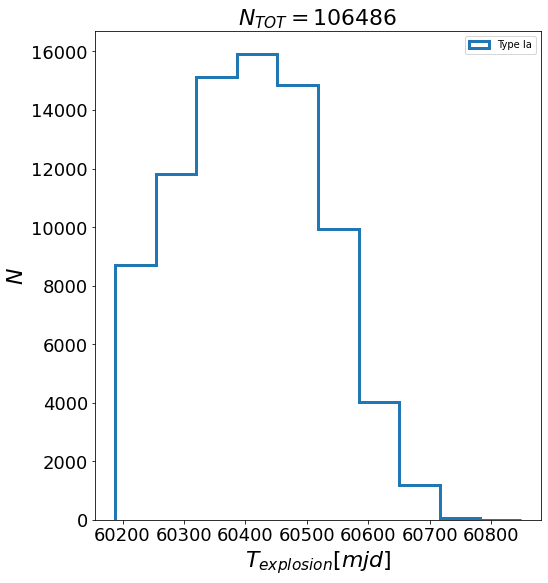

In [42]:
fig, ax=plt.subplots(1,figsize=(8,9))
for i, key in enumerate(df17.keys()):    
    explt=np.concatenate(df17[key]['time_expl'])
    ax.hist(explt,10, histtype='step',linewidth=3,align='left',label='Type Ia')
ax.set_xlabel(r'$T_{explosion}[mjd]$',fontsize=22)
ax.set_ylabel(r'$N$',fontsize=22)
ax.set_title(r'$N_{TOT}=106486$',fontsize=22)
ax.tick_params('both', labelsize=18)
plt.legend()
#plt.savefig('./Figure/hist_expl_v1.4_sD1_nexp37_nsn1_Ia.pdf')

In [22]:
def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec

In [23]:
ra, dec = pix2radec(16,np.concatenate([df17['Ia_test']['class'][i]['pixId'] for i in range(len(df17['Ia_test']['class']))]))

In [24]:
from pylab import cm
def plt_mlw(ax,ra,dec,org=0,projection='mollweide',c= 'null', vmin=0,vmax=1, dicts={}):
    args={'colormap': None,'marker':'o','linewidths':0,'title':'mlw_plot','xlabel':'x','ylabel':'y', 'fontsize':12,'cbartitle': 'score','psize':100}
    if dicts:
        args.update(dicts)
    if args['colormap']:
        cmap = cm.get_cmap(args['colormap'])
    else:
        cmap=None
        
    if c =='null':
        c= np.ones(len(ra))
    else:
        c=c
     
    x = np.remainder(ra+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    #ax = fig.add_subplot(111, projection=projection)
    ax.set_title(args['title'])
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis    
    ax.title.set_fontsize(12)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    im=plt.scatter(np.radians(x),np.radians(dec),c=c, s=args['psize'],cmap=cmap, marker = args['marker'], vmin = vmin, vmax = vmax, linewidths = args['linewidths'], zorder = 10)
    #ax.tick_params('both', labelsize=14)
    if cmap:
        cb=plt.colorbar(im,aspect=50,orientation='horizontal')
        cb.set_label(args['cbartitle'], size=12)
        for t in cb.ax.get_xticklabels():
             t.set_fontsize(12)

In [128]:
df17['Ia_test']['class'][0].index

Float64Index([0.1, 0.8], dtype='float64')

### Fraction of correctly classified SNe as function of number of visits

In [232]:
fractions={'Ia':None,'II':None,'Ibc':None}
nvis=[]
for j, key in enumerate(fractions.keys()):
    c = np.zeros(np.size(df17['Ia_test']['class']))
    for l,k in enumerate(df17['Ia_test']['class'][0].index):
        o=[]
        for i in range(len(df17['Ia_test']['class'])):
            if df17['Ia_test']['class'][i].iloc[l]['nlc'][0]!=0:
                o.append(df17['Ia_test']['class'][i].iloc[l][key]/df17['Ia_test']['class'][i].iloc[l]['nlc'][0])
            else:
                o.append(0)
            
        c+=np.array(o)
        
    fractions[key]=c/2
for i in range(len(df17['Ia_test']['class'])):
    nvis.append(np.size(df17['get_Col']['observationStartMJD'][i]))

In [233]:
zfractions={'Ia':{z:None for z in df17['Ia_test']['class'][0].index},
            'II':{z:None for z in df17['Ia_test']['class'][0].index},
            'Ibc':{z:None for z in df17['Ia_test']['class'][0].index}}
for j, key in enumerate(fractions.keys()):
    c = np.zeros(np.size(df17['Ia_test']['class']))
    for l,k in enumerate(df17['Ia_test']['class'][0].index):
        o=[]
        for i in range(len(df17['Ia_test']['class'])):
            if df17['Ia_test']['class'][i].iloc[l]['nlc'][0]!=0:
                o.append(df17['Ia_test']['class'][i].iloc[l][key]/df17['Ia_test']['class'][i].iloc[l]['nlc'][0])
            else:
                o.append(0)
           
        zfractions[key][k]=np.array(o)

In [251]:
nvis=np.array(nvis)

In [252]:
mask = np.where((nvis>40))
mask_vis = np.where(nvis<40)

Text(0, 0.5, '$f^{ Ia}_{class}$')

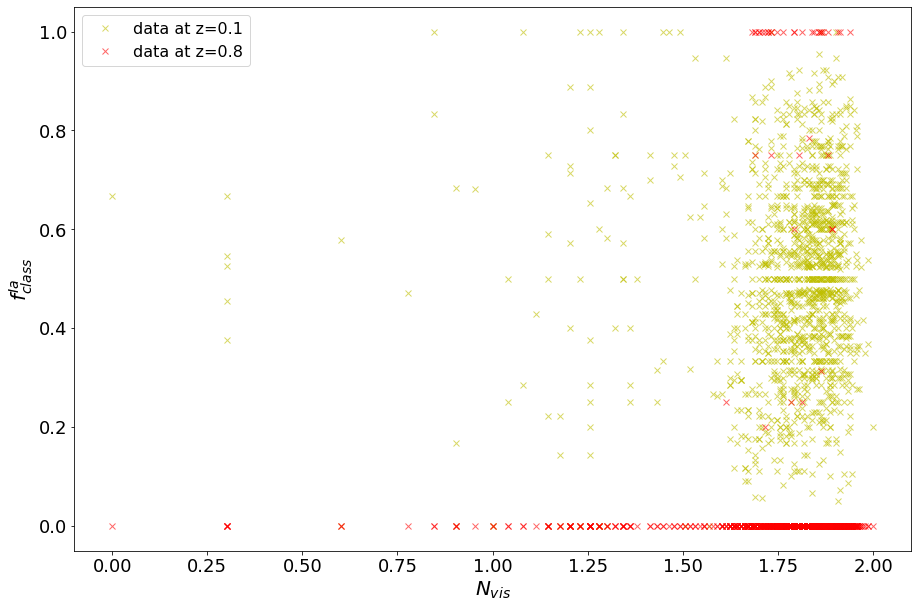

In [261]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
for z,c in zip(zfractions['Ia'].keys(),['y', 'red']):
    ax.plot(np.log10(nvis), zfractions['Ia'][z], "x", color=c,alpha=0.6,label="data at z={}".format(z))
plt.legend(fontsize=16)
ax.tick_params('both', labelsize=18)
ax.set_xlabel(r"$N_{vis}$",fontsize=20)
ax.set_ylabel(r"$f^{ Ia}_{class}$",fontsize= 20)
#ax[1].plot(np.log(nvis[mask_vis]), fractions['Ia'][mask_vis], "x", label="data")
#ax[2].plot(np.log(nvis[mask]), fractions['Ia'][mask], "x", label="data")

In [146]:
from pymc3 import *

In [253]:
#
with Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = Normal("Intercept", 0, sigma=20)
    x_coeff = Normal("x", 0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=intercept + x_coeff * np.log10(nvis[mask]), sigma=sigma, observed=fractions['Ia'][mask])

    # Inference!
    trace = sample(3000, cores=2)  # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 93 seconds.


<Figure size 504x504 with 0 Axes>

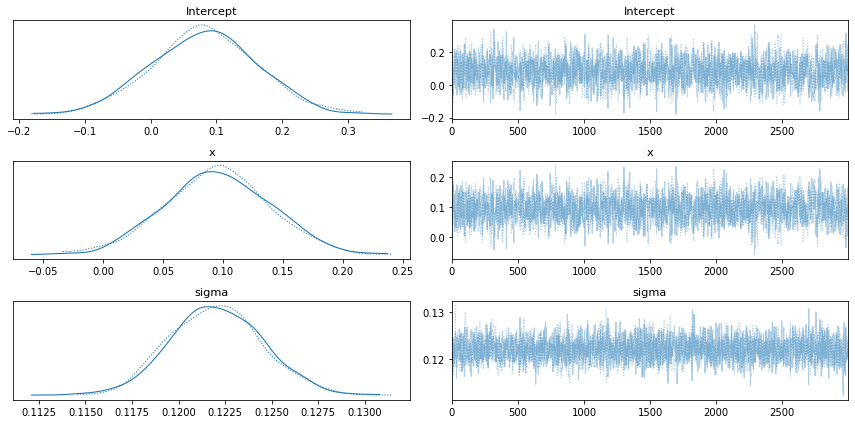

In [254]:
plt.figure(figsize=(7, 7))
traceplot(trace)
plt.tight_layout();

covariance matrix
[[0.03680999 0.00135711]
 [0.00135711 0.01555452]]


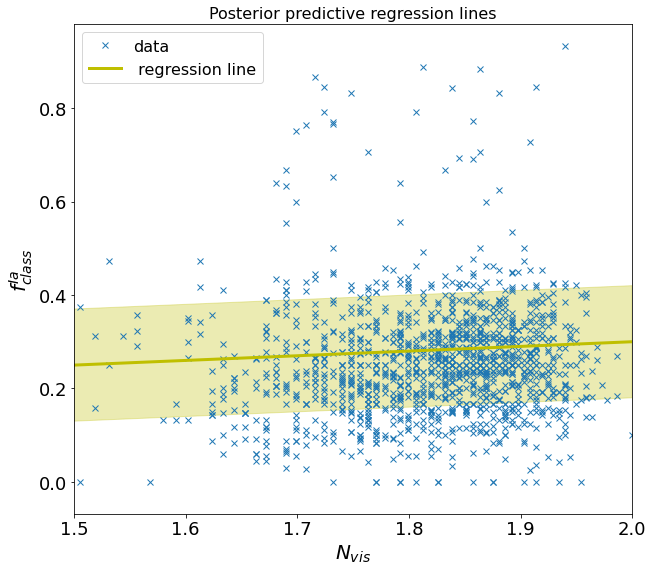

In [262]:
x = np.linspace(1,100, np.size(fractions['Ia']))
fig, ax=plt.subplots(1,1,figsize=(10, 9))
ax.plot(np.log10(nvis), fractions['Ia'], "x", label="data")
ax.fill_between(np.log10(x), np.log10(x)*0.1+0.1 - 0.12, np.log10(x)*0.1+0.1 + 0.12,
                    color='y', alpha=0.3)
ax.plot(np.log10(x),np.log10(x)*0.1+0.1, label=" regression line", lw=3.0, c="y")
ax.set_xlim([1.5,2])
ax.set_title("Posterior predictive regression lines",fontsize=16)
plt.legend(loc=0,fontsize=16)
ax.tick_params('both', labelsize=18)
ax.set_xlabel(r"$N_{vis}$",fontsize=20)
ax.set_ylabel(r"$f^{ Ia}_{class}$",fontsize= 20)
print('covariance matrix')
print(np.cov(np.log10(nvis), fractions['Ia']))

{'Ia': {0.1: 0.4961785386731886, 0.8: 0.1121771217712177}}

### Fraction of correctly classified SNe as function of redshift

In [26]:
zfrac={'Ia':{z:0 for z in [0.1,0.8]}}#,'II':{z:0 for z in [0.1,0.8]},'Ibc':{z:0 for z in [0.1,0.8]}}
miss_class= {'Ia':{'II':{z:0 for z in [0.1,0.8]},'Ibc':{z:0 for z in [0.1,0.8]}}}#,'II':{'Ia':{z:0 for z in [0.1,0.8]},'Ibc':{z:0 for z in [0.1,0.8]}},'Ibc':{'Ia':{z:0 for z in [0.1,0.8]},'II':{z:0 for z in [0.1,0.8]}}}
for j, key in enumerate(zfrac.keys()):
    for l,k in enumerate(zfrac[key].keys()):
        c=0
        norm = np.sum(np.array([df17['Ia_test']['class'][i].iloc[l]['nlc'][0] for i in range(len(df17['Ia_test']['class']))]))
        if norm ==0:
            p=0
        else:
            p=np.sum(np.array([df17['Ia_test']['class'][i].iloc[l][key] for i in range(len(df17['Ia_test']['class']))]))/norm
        zfrac[key][k] += p
        
for j, key in enumerate(miss_class.keys()):
    for j, mk in enumerate(miss_class[key].keys()):
        for l,k in enumerate(miss_class[key][mk].keys()):
            norm = np.sum(np.array([df17['Ia_test']['class'][i].iloc[l]['nlc'][0] for i in range(len(df17['Ia_test']['class']))]))
            if norm==0:
                p=0
            else:
                p=np.sum(np.array([df17['Ia_test']['class'][i].iloc[l][mk] for i in range(len(df17['Ia_test']['class']))]))/norm
            miss_class[key][mk][k] += p

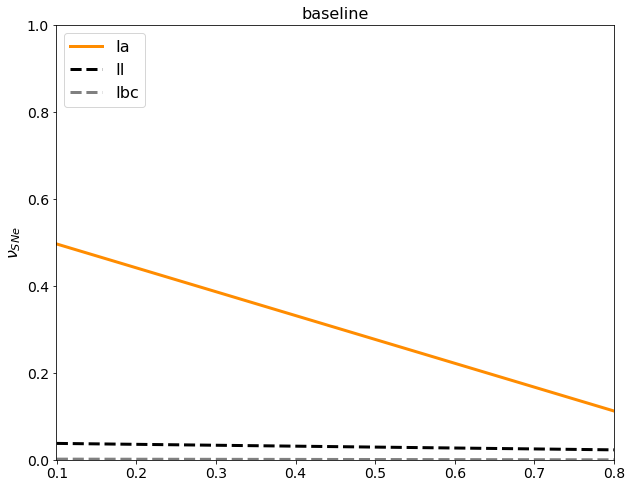

In [125]:
fig, axes = plt.subplots(1,1,figsize=(10,8))
for i, (t,c) in enumerate(zip(zfrac.keys(),['darkorange','forestgreen', 'cyan'])):
    if t=='Ia':
        m1,m2='II','Ibc'
    elif t=='II':
        m1,m2='Ia','Ibc'
    elif t=='Ibc':
        m1,m2='Ia','II'
    axes.plot(zfrac[t].keys(),np.array([ zfrac[t][k] for k in zfrac[t].keys()]),'-',lw=3,color = c ,label=t)
    axes.plot(zfrac[t].keys(),np.array([ miss_class[t][m1][k] for k in zfrac[t].keys()]),'--',lw=3,color = 'black' ,label=m1)
    axes.plot(zfrac[t].keys(),np.array([ miss_class[t][m2][k] for k in zfrac[t].keys()]),'--',lw=3,color = 'gray' ,label=m2)    
    axes.set_ylabel(r'$\nu_{SNe}$', fontsize=16)
    axes.set_xlim([0,1])
    axes.set_xlim([0.099,0.8])
    axes.tick_params('both', labelsize=14)
    axes.legend(loc=2,fontsize=16)
    axes.set_title('baseline', fontsize=16)
    axes.set_ylim([0,1])
#plt.savefig('./Figure/class_redshift.pdf')

In [29]:
no_class_frac={'Ia':{z:0 for z in [0.1,0.8]}}#,'II':{z:0 for z in [0.1,0.8]},'Ibc':{z:0 for z in [0.1,0.8]}}
for j, key in enumerate(zfrac.keys()):
    for l,k in enumerate(zfrac[key].keys()):
        c=0
        norm = np.sum(np.array([np.sum(df17['Ia_test']['class'][i].iloc[l]['nlc']) for i in range(len(df17['Ia_test']['class']))]))
        if norm ==0:
            p=0
        else:
            p=np.sum(np.array([df17['Ia_test']['class'][i].iloc[l]['nlc'][1] for i in range(len(df17['Ia_test']['class']))]))/norm
        no_class_frac[key][k] += p


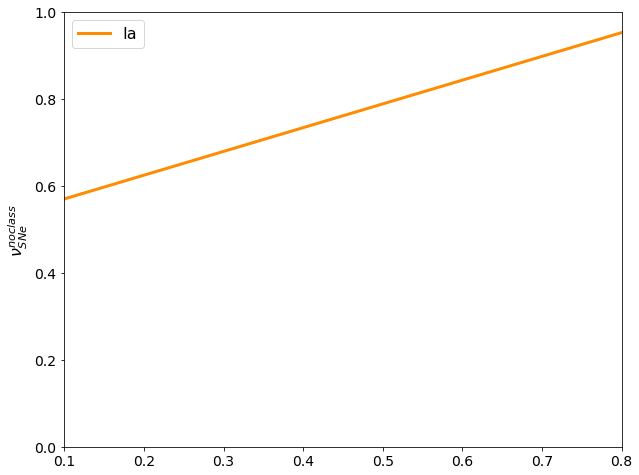

In [32]:
fig, axes = plt.subplots(1,1,figsize=(10,8))
for i, (t,c) in enumerate(zip(zfrac.keys(),['darkorange','forestgreen', 'cyan'])):
    axes.plot(zfrac[t].keys(),np.array([no_class_frac[t][k] for k in zfrac[t].keys()]),'-',lw=3,color = c ,label=t)
    axes.set_ylabel(r'$\nu^{no class}_{SNe}$', fontsize=16)
    axes.set_xlim([0.099,0.8])
    axes.tick_params('both', labelsize=14)
    axes.legend(loc=2,fontsize=16)
    axes.set_ylim([0,1])
#plt.savefig('./Figure/unclass_redshift.pdf')

In [30]:
import pickle
with open('simulations_class.p','wb') as fout:
    pickle.dump(df,fout)

### Skymap of the fraction of correctly classified SNe

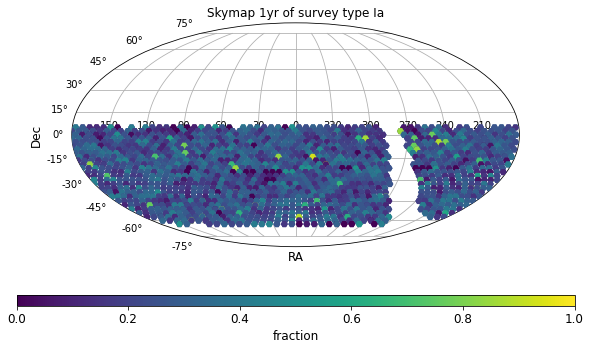

In [200]:
fig=plt.figure(figsize=(10,20))
for j, key in enumerate(['Ia']):
    ax= fig.add_subplot(3,1,j+1, projection='mollweide')
    plt_mlw(ax,ra,dec,c=np.concatenate([fractions[key],fractions[key]]),vmin=0,vmax=1,dicts={'marker':'H','cbartitle':'fraction','colormap':'viridis','title': 'Skymap 1yr of survey type {}'.format(key),'psize':50})
#plt.savefig('./Figure/skymap_fraction.pdf')

### Distribution of the number of visits

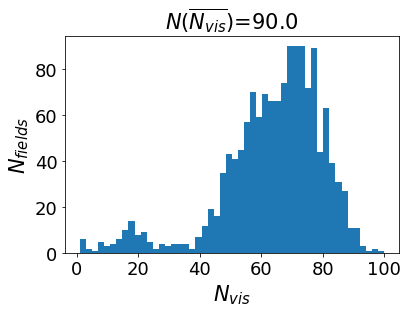

In [198]:
v,b,f = plt.hist(nvis, bins=50)
plt.title(r'$N(\overline{N_{vis}})$'+'={}'.format(np.amax(v)), fontsize=21)
plt.xlabel(r'$N_{vis}$', fontsize=21)
plt.ylabel(r'$N_{fields}$', fontsize=21)
plt.tick_params('both', labelsize=18)
plt.show()
